In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
from argparse import Namespace
import copy
import gzip
import itertools
import os
import pickle
import sys
import typing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.ast_mcmc_regrowth import *

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


98 6272 64.0 100352 1024.0


In [4]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,1.00,...,0.975856,0.984382,0.970248,0.981414,0.981920,0.983617,0.919078,0.916083,0.975543,0.987520
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,1.00,...,0.985632,0.986181,0.966645,0.978594,0.977472,0.984273,0.921563,0.932350,0.946308,0.962481
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,0.00,...,0.975984,0.980604,0.000000,0.000000,0.000000,0.000000,0.844787,0.859283,0.923957,0.942713
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,0.00,...,0.986042,0.985931,0.000000,0.000000,0.000000,0.000000,0.919078,0.916083,0.975543,0.987520
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0.25,...,0.984624,0.983172,0.000000,0.000000,0.000000,0.000000,0.976741,0.978604,0.971680,0.987572


# Plan of attack
* Use the code in `ast_counter_sampler.py` to generate a sample from the MLE
* Score it with a fitness function adapted to working with a single example at a time
* At each subsequent iteration, regrow the game from a random node, and score the regrowth
* Since we have energy scores before and after, we can either accept greedily if $E_{new} < E_{old}$, or accept with probability $\exp(\beta (E_{old} - E_{new} ))$

In [16]:
DEFAULT_ARGS = argparse.Namespace(
    grammar_file=os.path.join('..', DEFAULT_GRAMMAR_FILE),
    parse_counter=False,
    counter_output_path=os.path.join('..', DEFAULT_COUNTER_OUTPUT_PATH),
    random_seed=DEFUALT_RANDOM_SEED,
)

In [17]:
# FITNESS_MODEL_DATE_ID = 'full_features_2023_03_29'
# FITNESS_FEATURIZER_PATH = '../models/fitness_featurizer_2023_03_29.pkl.gz'


# mcmc = MCMCRegrowthSampler(DEFAULT_ARGS,
#     FITNESS_MODEL_DATE_ID, FITNESS_FEATURIZER_PATH, greedy_acceptance=True, 
#     plateau_patience_steps=1000, max_steps=20000,
#     relative_path='..')  #   acceptance_temperature=10.0, 

In [18]:
mcmc = utils.load_data('2023_04_07', 'samples', 'mcmc_full_features')
len(mcmc.samples)

100

-0.6543572998046875 1.053917292783274
54 0.54


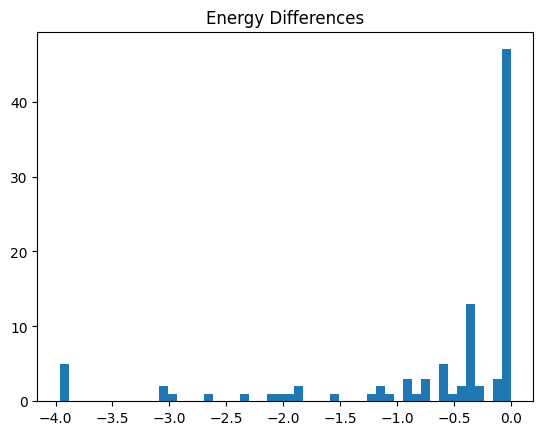

In [19]:
energy_differences = np.array([sample[2] - sample[5] for sample in mcmc.samples])
print(np.mean(energy_differences), np.std(energy_differences))
n_changes = (energy_differences != 0).sum()
print(n_changes, n_changes / len(energy_differences))
plt.hist(energy_differences, bins=50)
plt.title('Energy Differences')
plt.show()

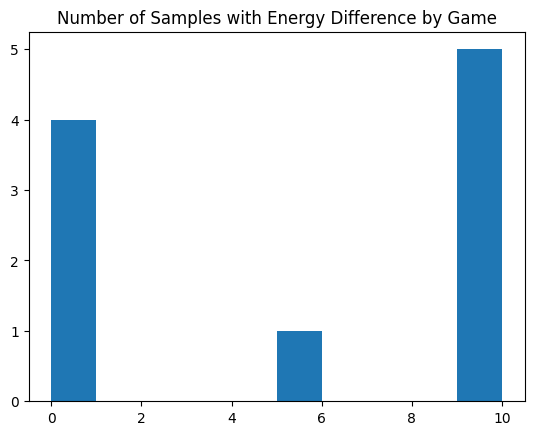

In [20]:
n_samples_per_game = 10
energy_differences_by_game = energy_differences.reshape(-1, n_samples_per_game)
number_of_changes_by_game = (energy_differences_by_game != 0).sum(axis=1)
plt.hist(number_of_changes_by_game, bins=10)
plt.title('Number of Samples with Energy Difference by Game')
plt.show()

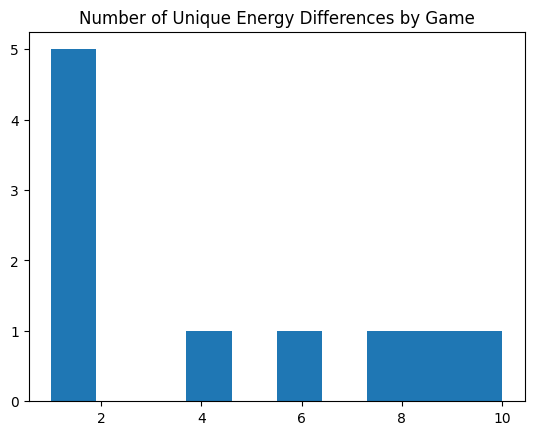

In [21]:
unique_differences_by_game = np.sort(energy_differences_by_game, axis=1)
unique_differences_by_game = (unique_differences_by_game[:,1:] != unique_differences_by_game[:,:-1]).sum(axis=1)+1
# unique_differences_by_game[number_of_changes_by_game > 0]
plt.hist(unique_differences_by_game, bins=10)
plt.title('Number of Unique Energy Differences by Game')
plt.show()

In [22]:
np.argwhere((energy_differences_by_game == 0).sum(axis=1) == 10).squeeze()

array([0, 2, 7, 8])

In [23]:
set(np.argwhere(unique_differences_by_game == 1).squeeze()) - set(np.argwhere((energy_differences_by_game == 0).sum(axis=1) == 10).squeeze())

{3}

In [24]:
mcmc.visualize_sample_with_energy_difference(0)

The 0 sample with an energy difference is the 10 sample.


### Energy of real game: -65.180 | Energy of regrown game: -69.141 | Difference: -3.962

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                             | Features decreasing energy (= more real)                                                  |
|--------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| adjacent_arg_types_agent_furniture_constraints: **0.345** = (0.000 => 1.000) * 0.345 | ast_ngram_setup_n_5_score: **-1.813** = (0.706 => 0.947) * -7.508                         |
|                                                                                      | ast_ngram_full_n_7_score: **-1.337** = (0.891 => 0.943) * -26.009                         |
|                                                                                      | ast_ngram_constraints_n_7_score: **-0.619** = (0.957 => 0.989) * -19.124                  |
|                                                                                      | adjacent_arg_types_agent_room_features_constraints: **-0.473** = (1.000 => 0.000) * 0.473 |
|                                                                                      | ast_ngram_terminal_n_5_score: **-0.042** = (0.984 => 1.000) * -2.678                      |
|                                                                                      | ast_ngram_scoring_n_5_score: **-0.022** = (0.927 => 0.933) * -3.535                       |

### Game Diffs

f,1,(define (game 5f77754ba932fb2c4ba181d8-2) (:domain many-objects-room-v1),f,1,(define (game 5f77754ba932fb2c4ba181d8-2) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(game-conserved,,4,(game-conserved
n,5,(open top_drawer),n,5,(open bed)
,6,),,6,)
,7,),,7,)
,8,),,8,)
,9,(:constraints,,9,(:constraints
,10,(and,,10,(and
n,11,(forall (?b - (either dodgeball golfball) ?t - (either top_drawer hexagonal_bin)),n,11,(forall (?b - ball ?t - (either top_drawer hexagonal_bin))


### Feature Diffs

adjacent_arg_types_agent_room_features_constraints: -1.000 (1.000 => 0.000)
ast_ngram_scoring_n_5_score: 0.006 (0.927 => 0.933)
ast_ngram_terminal_n_5_score: 0.016 (0.984 => 1.000)
ast_ngram_constraints_n_7_score: 0.032 (0.957 => 0.989)
ast_ngram_full_n_7_score: 0.051 (0.891 => 0.943)
ast_ngram_setup_n_5_score: 0.242 (0.706 => 0.947)
adjacent_arg_types_agent_furniture_constraints: 1.000 (0.000 => 1.000)


In [14]:
mcmc.fitness_featurizer.parse(mcmc.samples[10][0], '')

In [ ]:
m = fitness_df.groupby('real').in_arg_types_other_constraints.mean()
m
# m.loc[1] - m.loc[0]

In [ ]:
fitness_df[(fitness_df.real == 1) & (fitness_df.in_arg_types_other_constraints == 1)]

## Regrwoth from existing games

In [ ]:
n_samples = 5
n_games = 10
start = 25
end = start + n_games


for original_index in range(start, end):
    print(f'Generating samples starting from original index {original_index} (id {_extract_game_id(real_game_texts[original_index])})')
    mcmc.multiple_samples(n_samples, verbose=1, should_tqdm=False, initial_proposal=game_asts[original_index], postprocess=False)

    # print()
    # for i in range(n_samples * (original_index - start), n_samples * (original_index - start + 1)):
    #     print(i, mcmc.samples[i][2])

In [ ]:
len(mcmc.samples)

In [ ]:
mcmc.visualize_sample(11)

In [ ]:
mcmc.samples[75][0][4][1].preferences.definition.forall_pref.preferences.pref_body.body.exists_args.then_funcs[0].seq_func.once_pred.pred.and_args[-1].pred

In [ ]:
mcmc.samples[11][0][5][1]

In [ ]:
from ast_parser import ASTBooleanParser
bp = ASTBooleanParser()
bp.evaluate_tautology(bp(mcmc.samples[11][0][5][1], section='(:terminal'))
# bp(mcmc.samples[75][0][4][1].preferences.definition.forall_pref.preferences.pref_body.body.exists_args.then_funcs[0].seq_func.once_pred.pred.and_args[-1].pred, section='(:constraints')

In [ ]:
import ast_utils
terminal = copy.deepcopy(mcmc.samples[11][3][5][1])
ast_utils.replace_child(terminal.terminal, 'expr_1', '400')
bp.game_start()
bp(terminal, section='(:terminal')

In [ ]:
from argparse import Namespace
from src.fitness_features import *
args = Namespace(no_binarize=False, no_merge=False)
featurizer = build_fitness_featurizer(args)

In [ ]:
mcmc.fitness_featurizer.parse(mcmc.samples[50][0], 'mcmc', True, True)['ast_ngram_scoring_n_5_score']

In [ ]:
ps = {k:v for k, v in featurizer.parse(mcmc.samples[37][0], 'mcmc', True, False).items() if 'all_variables' in k}
ps

In [ ]:
# %prun -r 
n_samples = 5
start = 0
end = start + n_samples

for original_index in range(start, end):
    print(f'Generating samples starting from original index {original_index} (id {_extract_game_id(real_game_texts[original_index])})')
    mcmc.multiple_samples(n_samples, verbose=1, should_tqdm=True, initial_proposal=game_asts[original_index])

    print()
    for i in range(n_samples * (original_index - start), n_samples * (original_index - start + 1)):
        print(i, mcmc.samples[i][2])

In [ ]:
mcmc.visualize_sample(14)

In [ ]:
mcmc.fitness_featurizer.full_text_registry[0].n_gram_model.models[-1].score(ast_printer.ast_to_string(mcmc.samples[14][0], ' '))

In [ ]:
mcmc.fitness_featurizer.full_text_registry[0].n_gram_model.models[-1].score(ast_printer.ast_to_string(mcmc.samples[14][3], ' '))

In [ ]:
ngram_model = mcmc.fitness_featurizer.full_text_registry[0].n_gram_model.models[-1]

sample_ngrams = [('constraints', 'and', 'forall', 'wall', 'and'), ('and', 'forall', 'wall', 'and', 'preference'), ('forall', 'wall', 'and', 'preference', 'preferenceName'), ('wall', 'and', 'preference', 'preferenceName', 'exists'), ('and', 'preference', 'preferenceName', 'exists', 'block'), ('preference', 'preferenceName', 'exists', 'block', 'atend'), ('preferenceName', 'exists', 'block', 'atend', 'in'), ('exists', 'block', 'atend', 'in', 'scoring'), ('block', 'atend', 'in', 'scoring', 'externalforallmaximize'), ('atend', 'in', 'scoring', 'externalforallmaximize', 'countonceperobjects'), ('in', 'scoring', 'externalforallmaximize', 'countonceperobjects', 'preferenceName')]
original_ngrams = [('constraints', 'and', 'forall', 'building', 'and'), ('and', 'forall', 'building', 'and', 'preference'), ('forall', 'building', 'and', 'preference', 'preferenceName'), ('building', 'and', 'preference', 'preferenceName', 'exists'), ('and', 'preference', 'preferenceName', 'exists', 'block'), ('preference', 'preferenceName', 'exists', 'block', 'atend'), ('preferenceName', 'exists', 'block', 'atend', 'in'), ('exists', 'block', 'atend', 'in', 'scoring'), ('block', 'atend', 'in', 'scoring', 'externalforallmaximize'), ('atend', 'in', 'scoring', 'externalforallmaximize', 'countonceperobjects'), ('in', 'scoring', 'externalforallmaximize', 'countonceperobjects', 'preferenceName')]

print(f'Sample ngrams: {np.mean([ngram_model.ngram_logprobs[s] for s in sample_ngrams])} | ')
for s in sample_ngrams:
    print(s, ngram_model.ngram_counts[s], ngram_model.ngram_logprobs[s])

print()
print(f'Original ngrams: {np.mean([ngram_model.ngram_logprobs[s] for s in original_ngrams])}')
for s in original_ngrams:
    print(s, ngram_model.ngram_counts[s], ngram_model.ngram_logprobs[s])
print()

for s in sample_ngrams[:]:
    if s in original_ngrams:
        sample_ngrams.remove(s)
        original_ngrams.remove(s)

print('Sample remaining ngrams')
for s in sample_ngrams:
    print(s, ngram_model.ngram_counts[s], ngram_model.ngram_logprobs[s])

print()
print('Original remaining ngrams')
for s in original_ngrams:
    print(s, ngram_model.ngram_counts[s], ngram_model.ngram_logprobs[s])

In [ ]:
original_ngrams = [('constraints', 'and', 'forall', 'building', 'and'), ('and', 'forall', 'building', 'and', 'preference'), ('forall', 'building', 'and', 'preference', 'preferenceName'), ('building', 'and', 'preference', 'preferenceName', 'exists'), ('and', 'preference', 'preferenceName', 'exists', 'block'), ('preference', 'preferenceName', 'exists', 'block', 'atend'), ('preferenceName', 'exists', 'block', 'atend', 'in'), ('exists', 'block', 'atend', 'in', 'scoring'), ('block', 'atend', 'in', 'scoring', 'externalforallmaximize'), ('atend', 'in', 'scoring', 'externalforallmaximize', 'countonceperobjects'), ('in', 'scoring', 'externalforallmaximize', 'countonceperobjects', 'preferenceName')]
print('Original ngrams')
for s in original_ngrams:
    print(s, mcmc.fitness_featurizer.full_text_registry[0].n_gram_model.models[-1].ngram_counts[s], mcmc.fitness_featurizer.full_text_registry[0].n_gram_model.models[-1].ngram_logprobs[s])

In [ ]:
mcmc.visualize_sample(7)

In [ ]:
mcmc.visualize_sample(15)

### Notes from looking at these games
* **TODO:** debug the 'section-without' logic, it seems to not work
* **TODO:** add features for preferences with different lengths of modals

In [ ]:
print(ast_printer.ast_to_string(samples[8][0], '\n'))

In [ ]:
fitness_featurizer = build_fitness_featurizer(DEFAULT_ARGS)
features = fitness_featurizer.parse(samples[7][0], 'mcmc', True)
{k: v for k, v in features.items() if 'correctly' in k or 'forall' in k or 'no' in k}

In [ ]:
with gzip.open(DEFAULT_FITNESS_FUNCTION_PATH, 'rb') as f:
    cv_fitness_model = pickle.load(f)

In [ ]:
weights = cv_fitness_model.named_steps['fitness'].model.fc1.weight.data.detach().numpy().squeeze()
bias = cv_fitness_model.named_steps['fitness'].model.fc1.bias.data.detach().numpy().squeeze()
print(weights.mean(), bias)

In [ ]:
plt.hist(weights, bins=100)
plt.title('Fitness Model Weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')

In [ ]:
import ast_crossover_sampler
asts = [ast for ast in cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', 
    mcmc.grammar_parser, False, relative_path='..')]

mcmc_with_crossover = MCMCRegrowthCrossoverSampler(DEFAULT_ARGS, 
    ast_crossover_sampler.CrossoverType.SAME_RULE, asts, 0.25,
    '../models/cv_fitness_model_2022_12_26.pkl.gz', 
    greedy_acceptance=True, plateau_patience_steps=20, acceptance_temperature=10.0, max_steps=1000)

In [ ]:
mcmc_with_crossover.multiple_samples(10, verbose=2, should_tqdm=True)
print([x[2] for x in mcmc_with_crossover.samples])

In [ ]:
print([x[2] for x in mcmc_with_crossover.samples])